In [1]:
import gdown
gdown.download('https://raw.githubusercontent.com/jordan-hay/jordan-hay.github.io/main/docs/assets/dea_data.csv','file.csv',quiet=True)

'file.csv'

In [2]:
!pip install gurobipy &>/dev/null

In [3]:
import pandas as pd
import gurobipy as gp
from gurobipy import GRB
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', None)

In [4]:
df=pd.read_csv('file.csv')
df.head()

,Unit,Marketing,Equipment,Facility Space,Labor,Online Presence,Electronics Sales,Home Garden Sales,Books Sales,Transactions
0,1,10016,1428,21741,2181,217047,786295,508688,910228,64688
1,2,7322,957,15853,1164,199133,630933,481664,643435,54866
2,3,8428,1956,26795,2973,292068,994486,841251,1209302,90375
3,4,11246,5355,26310,1645,303364,1138700,660708,1300112,88122
4,5,13174,3871,29444,4216,342460,1442283,936689,1425162,105192


In [5]:
dfcols=list(df.columns)
dfcols

['Unit',
 'Marketing',
 'Equipment',
 'Facility Space',
 'Labor',
 'Online Presence',
 'Electronics Sales',
 'Home Garden Sales',
 'Books Sales',
 'Transactions']

In [6]:
input_df =df[dfcols[1:6]]
input_cols=list(input_df.columns)
output_df =df[dfcols[6:10]]
output_cols=list(output_df.columns)

In [7]:
input_df.head()

,Marketing,Equipment,Facility Space,Labor,Online Presence
0,10016,1428,21741,2181,217047
1,7322,957,15853,1164,199133
2,8428,1956,26795,2973,292068
3,11246,5355,26310,1645,303364
4,13174,3871,29444,4216,342460


In [8]:
output_df.head()

,Electronics Sales,Home Garden Sales,Books Sales,Transactions
0,786295,508688,910228,64688
1,630933,481664,643435,54866
2,994486,841251,1209302,90375
3,1138700,660708,1300112,88122
4,1442283,936689,1425162,105192


In [9]:
# Convert dataframes to numpy arrays
inputs = input_df.values
outputs = output_df.values

# Number of decision-making units and variables
n_units, n_inputs = inputs.shape
n_outputs = outputs.shape[1]

In [10]:
storage=[]
for unit in range(n_units):
  # Create a model
  model = gp.Model("DEA")
  model.setParam('OutputFlag', 0)

  # Add decision variables
  u = model.addVars(n_outputs, vtype=GRB.CONTINUOUS, name="u",lb=0.0)
  v = model.addVars(n_inputs, vtype=GRB.CONTINUOUS, name="v",lb = 0.0)
  # Add objective function (to be minimized)
  model.setObjective(gp.quicksum(x*y for x,y in zip(outputs[unit],u.values()) ), GRB.MAXIMIZE)

  # Add constraints
  for input,output in zip(inputs,outputs):
      model.addConstr(gp.quicksum(x*y for x,y in zip(output,u.values()) ) <= gp.quicksum(x*y for x,y in zip(input,v.values()) ))

  model.addConstr(gp.quicksum(x*y for x,y in zip(inputs[unit],v.values()) ) == 1)
  # Solve the model
  model.optimize()
  if model.status==2:
    print('OPTIMAL')
  else:
    print('*****')

  sp=[constr.Pi for constr in model.getConstrs()][0:-1]

  efficientin=[]
  for i in range(n_inputs):
    efficientin.append(np.dot(sp,inputs[:,i]))

  efficientout=[]
  for i in range(n_outputs):
    efficientout.append(np.dot(sp,outputs[:,i]))


  for i in range(n_inputs):
    imp = np.round(np.abs((np.dot(sp,inputs[:,i])-inputs[unit,i])/inputs[unit,i])*100,1)
    storage.append((unit,input_cols[i],'input',imp))
  for i in range(n_outputs):
    imp = np.round(np.abs((np.dot(sp,outputs[:,i])-outputs[unit,i])/outputs[unit,i])*100,1)

    storage.append((unit,output_cols[i],'output',imp))



Restricted license - for non-production use only - expires 2024-10-28
OPTIMAL
OPTIMAL
OPTIMAL
OPTIMAL
OPTIMAL
OPTIMAL
OPTIMAL
OPTIMAL
OPTIMAL
OPTIMAL
OPTIMAL
OPTIMAL
OPTIMAL
OPTIMAL
OPTIMAL
OPTIMAL
OPTIMAL
OPTIMAL
OPTIMAL
OPTIMAL
OPTIMAL
OPTIMAL
OPTIMAL
OPTIMAL
OPTIMAL
OPTIMAL
OPTIMAL
OPTIMAL
OPTIMAL
OPTIMAL
OPTIMAL
OPTIMAL
OPTIMAL
OPTIMAL
OPTIMAL
OPTIMAL
OPTIMAL
OPTIMAL
OPTIMAL
OPTIMAL
OPTIMAL
OPTIMAL
OPTIMAL
OPTIMAL
OPTIMAL
OPTIMAL
OPTIMAL
OPTIMAL
OPTIMAL
OPTIMAL
OPTIMAL
OPTIMAL
OPTIMAL
OPTIMAL
OPTIMAL
OPTIMAL
OPTIMAL
OPTIMAL
OPTIMAL
OPTIMAL
OPTIMAL
OPTIMAL
OPTIMAL
OPTIMAL
OPTIMAL
OPTIMAL
OPTIMAL
OPTIMAL
OPTIMAL
OPTIMAL


In [11]:
df_final=pd.DataFrame(storage,columns=['Unit','Attribute','Type','Improvement Opportunity'])
df_final.head()

,Unit,Attribute,Type,Improvement Opportunity
0,0,Marketing,input,2.8
1,0,Equipment,input,2.8
2,0,Facility Space,input,5.5
3,0,Labor,input,2.8
4,0,Online Presence,input,2.8


In [12]:
df_final.shape

(630, 4)

In [13]:
pvdf=pd.pivot_table(data=df_final[df_final.Type=='output'],index=['Unit'],columns=['Attribute'],values=['Improvement Opportunity'],aggfunc=np.sum)
pvdf.columns = pvdf.columns.droplevel()
pvdf.head()

Attribute,Books Sales,Electronics Sales,Home Garden Sales,Transactions
Unit,,,,
0,0.0,6.8,19.2,2.8
1,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0


In [14]:
pvdf.max()

Attribute
Books Sales          61.1
Electronics Sales    60.2
Home Garden Sales    72.6
Transactions         15.7
dtype: float64

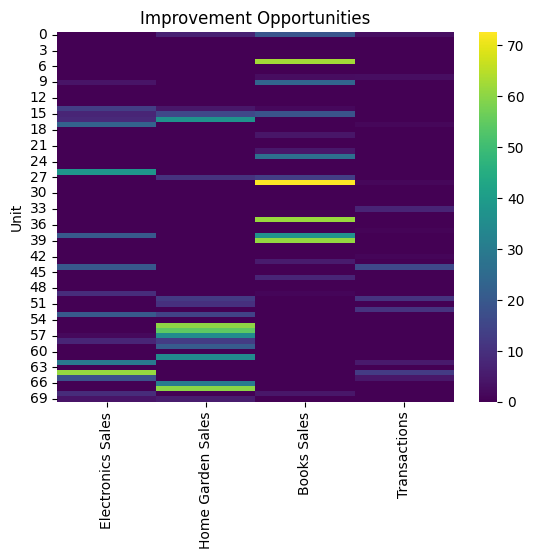

In [15]:
import seaborn as sns
sns.heatmap(pvdf.values,xticklabels=output_cols,cmap='viridis');
plt.title("Improvement Opportunities");
plt.ylabel('Unit');

In [16]:
pvdf=pd.pivot_table(data=df_final[df_final.Type=='input'],index=['Unit'],columns=['Attribute'],values=['Improvement Opportunity'],aggfunc=np.sum)
pvdf.columns = pvdf.columns.droplevel()
pvdf.head()

Attribute,Equipment,Facility Space,Labor,Marketing,Online Presence
Unit,,,,,
0,2.8,5.5,2.8,2.8,2.8
1,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0


In [17]:
pvdf.max()

Attribute
Equipment          87.8
Facility Space     27.5
Labor              66.1
Marketing          64.2
Online Presence    62.2
dtype: float64

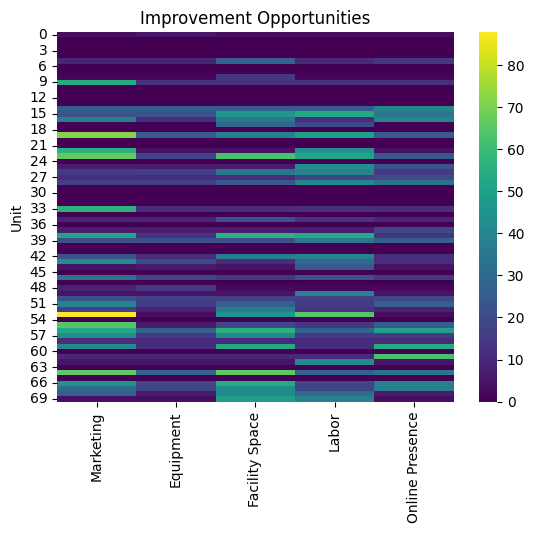

In [18]:
import seaborn as sns
sns.heatmap(pvdf.values,xticklabels=input_cols,cmap='viridis')
plt.title("Improvement Opportunities");
plt.ylabel('Unit');